# Advanced PyMC3: What the heck is ADVI?
![PyMC3][logo]
[logo]: https://raw.githubusercontent.com/pymc-devs/pymc3/master/docs/pymc3_logo.jpg "Logo"

Peadar Coyle - Contributor

In [1]:
%matplotlib inline
from IPython.display import HTML


In [2]:

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from matplotlib.animation import ArtistAnimation
from matplotlib.patches import Ellipse
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = 12, 4
rndst = np.random.RandomState(0)

%load_ext watermark
%watermark -dmvgp numpy,pandas,matplotlib,pymc3,theano,joblib

2017-05-05 

CPython 3.5.2
IPython 5.1.0

numpy 1.11.1
pandas 0.18.1
matplotlib 2.0.0
pymc3 3.1rc3
theano 0.9.0
joblib 0.11

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 4.8.0-36-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 4b44ea86962354f915bad7bfa5e3e65b2e6365e0


In [7]:
# configure pyplot for readability when rendered as a slideshow and projected
plt.rc('figure', figsize=(8, 6))

LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

plt.rc('animation', writer='avconv')

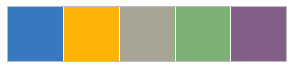

In [8]:
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
sns.palplot(sns.xkcd_palette(colors))

In [9]:
SEED = 69972 # from random.org, for reproducibility

np.random.seed(SEED)

# Variational inference
PyData London 2017
**Peadar Coyle**
:logo: http://elevatedirect.com/wp-content/uploads/2015/02/Linkedin-logo-color-500x207.jpg


## Bayesian Inference
<img src="http://upload.wikimedia.org/wikipedia/commons/1/18/Bayes'_Theorem_MMB_01.jpg" width=600>

The posterior distribution is equal to the joint distribution divided by the marginal distribution of the evidence.
$$\color{red}{P(\theta\ |\ \mathcal{D})}
    = \frac{\color{blue}{P(\mathcal{D}\ |\ \theta)\ P(\theta)}}{\color{green}{P(\mathcal{D})}}
    = \frac{\color{blue}{P(\mathcal{D}, \theta)}}{\color{green}{\int P(\mathcal{D}\ |\ \theta)\ P(\theta)\ d\theta}}$$
For many useful models the marginal distribution of the evidence is hard or impossible to calculate analytically.


## Why Variational inference? 
* Scaling probabilistic modelling to increasingly compex problems on increasingly large datasets. 

**PyMC3**: Variational inference: ADVI for fast approximate posterior estimation as well as mini-batch ADVI for large data sets.

**Uses** 
* Large scale topic models (LDA, Hierarchical Dirichlet Process)
* Semi-supervised classification
* Generative models of images

**Limitations**
* One limitation: Variational Inference requires that intractable distributions be approximated by a class of known probability distributions. 

**Objection**
Unlike MCMC, even in the asymptotic regime we are unable to recover the true posterior distribution.
*There are solutions* 
We can use a method called **normalized flows** and there are other research areas - this is out of the scope of this talk. There is work being done on this in PyMC3.

- [http://proceedings.mlr.press/v37/rezende15.pdf](http://proceedings.mlr.press/v37/rezende15.pdf) and 

**We'll assume that these limitations don't apply to our case** 

# Reading in the data.
* We'll use one of the Concrete Data Sets from UCI. 
Concrete mixture data: Yeh (1998) used designed experiments to find concrete formulations that maximize compressive strength. The data used here consists of separate experiments from 17 sources with common experimental factors were combined into one "meta–experiment". The data can be found in the UC Irvine Machine Learning Repository and in the AppliedPredictiveModeling R package.    


In [4]:
df = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/\
concrete/compressive/Concrete_Data.xls', 
                   names=['Cement','Slag', 'Fly_Ash', \
                          'Water', 'Superplasticizer', \
                          'Coarse_Aggregate', 'Fine_Aggregate',\
                          'Age_in_days', 'Concrete_compressive_strength'])

In [5]:
df.dtypes

Cement                           float64
Slag                             float64
Fly_Ash                          float64
Water                            float64
Superplasticizer                 float64
Coarse_Aggregate                 float64
Fine_Aggregate                   float64
Age_in_days                        int64
Concrete_compressive_strength    float64
dtype: object

# What should we predict or infer?
* I think we should predict the concrete_compressive_strength 

In [6]:
training_data = df[['Cement','Slag', 'Fly_Ash', 'Water', 'Superplasticizer', 
                    'Coarse_Aggregate', 'Fine_Aggregate', 'Age_in_days']]

In [7]:
training_data.head()

,Cement,Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age_in_days
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360


### Our first action is to add in some linear models.
* We'll run these linear models various ways.
* This is for illustration purposes. 

In [8]:
fts_num_smp = training_data.columns
ft_endog = 'Concrete_compressive_strength'
fml_all = '{} ~ '.format(ft_endog) + ' + '.join(fts_num_smp)

In [22]:

with pm.Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    pm.glm.GLM.from_formula(fml_all, df)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pm.sample(2000, step, progressbar=True) # draw 2000 posterior samples using NUTS sampling

         Current function value: 3932.790842
         Iterations: 87
         Function evaluations: 223
         Gradient evaluations: 210


100%|██████████| 2000/2000 [00:41<00:00, 48.15it/s]


In [23]:
with model:
    trc_met = pm.sample(10000, njobs=3, tune=1000, step=pm.Metropolis())


100%|██████████| 10000/10000 [01:02<00:00, 160.57it/s]


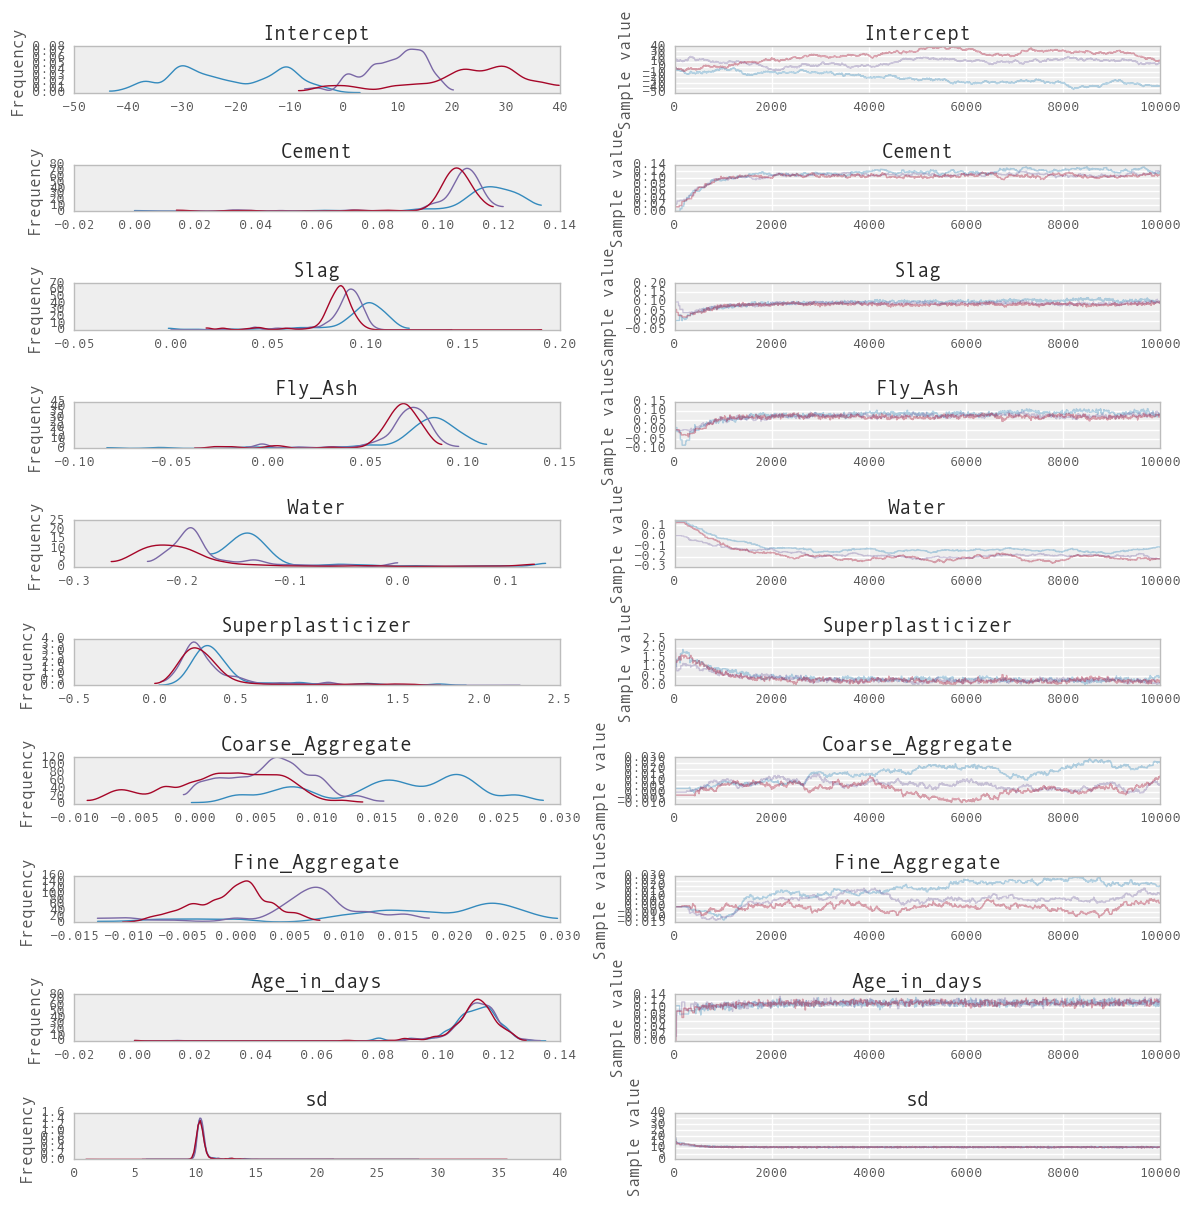

In [24]:
ax = pm.traceplot(trc_met[:], figsize=(12,4*3), combined=False)

Looks like this model isn't well specified. 
However we'll keep going even with a bad model. 

In [25]:
training_data.columns.tolist()

['Cement',
 'Slag',
 'Fly_Ash',
 'Water',
 'Superplasticizer',
 'Coarse_Aggregate',
 'Fine_Aggregate',
 'Age_in_days']

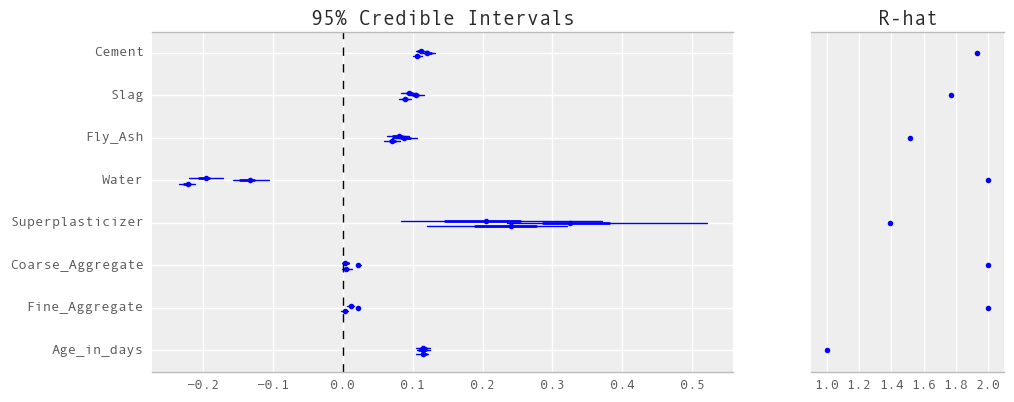

In [26]:
gs = pm.forestplot(trc_met[-1000:], varnames=training_data.columns.tolist())

These are well specified - with the exception of Wter and Superplasticizer. 
Let's see if ADVI could help

Average ELBO = -4,804.7: 100%|██████████| 40000/40000 [00:05<00:00, 7906.85it/s]   
Finished [100%]: Average ELBO = -4,447.9


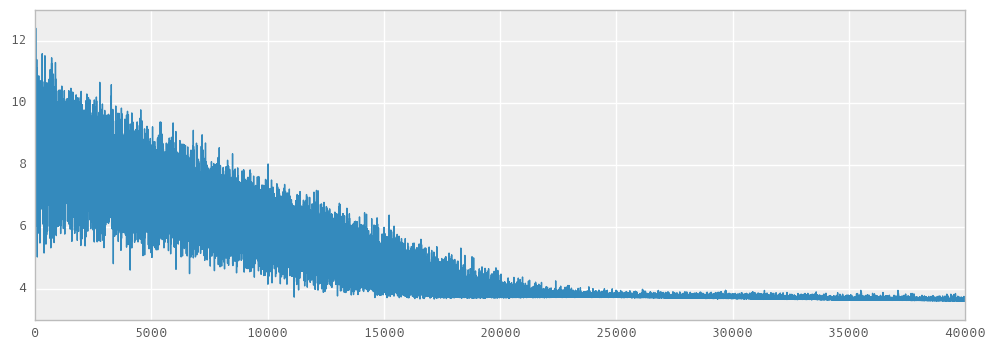

In [42]:
with model:
    v_params = pm.variational.advi(model=model, n=40000)


_ = plt.plot(np.log10(-v_params.elbo_vals))

**Observe**:
- ADVI takes many iterations to converge for this model, but it gets there in the end
- NOTE: I’ve plotted the ELBO on a log scale since the values swept through more than 10 orders of magnitude, and on a linear scale it becomes very hard to see convergence

In [21]:
df_v_means = pd.DataFrame(v_params.means, index=['mean'])
df_v_stds = pd.DataFrame(v_params.stds, index=['std'])
df_v_params = pd.merge(df_v_means.T, df_v_stds.T, left_index=True, right_index=True)
df_v_params

,mean,std
Age_in_days,0.114454,0.004666
Cement,0.113747,0.001209
Coarse_Aggregate,0.010700,0.000391
Fine_Aggregate,0.011813,0.000466
Fly_Ash,0.079824,0.004389
Intercept,-0.070436,0.365216
Slag,0.095781,0.003162
Superplasticizer,0.263064,0.043053
Water,-0.181842,0.001961
sd_log_,2.344487,0.024133


What do we want to do with these values?
We’ll use them to parameterise the NUTS sampler.

In [25]:

with model:
    trc_nuts = pm.sample(30000, njobs=3, step=pm.NUTS())

100%|██████████| 30000/30000 [18:23<00:00, 27.18it/s]


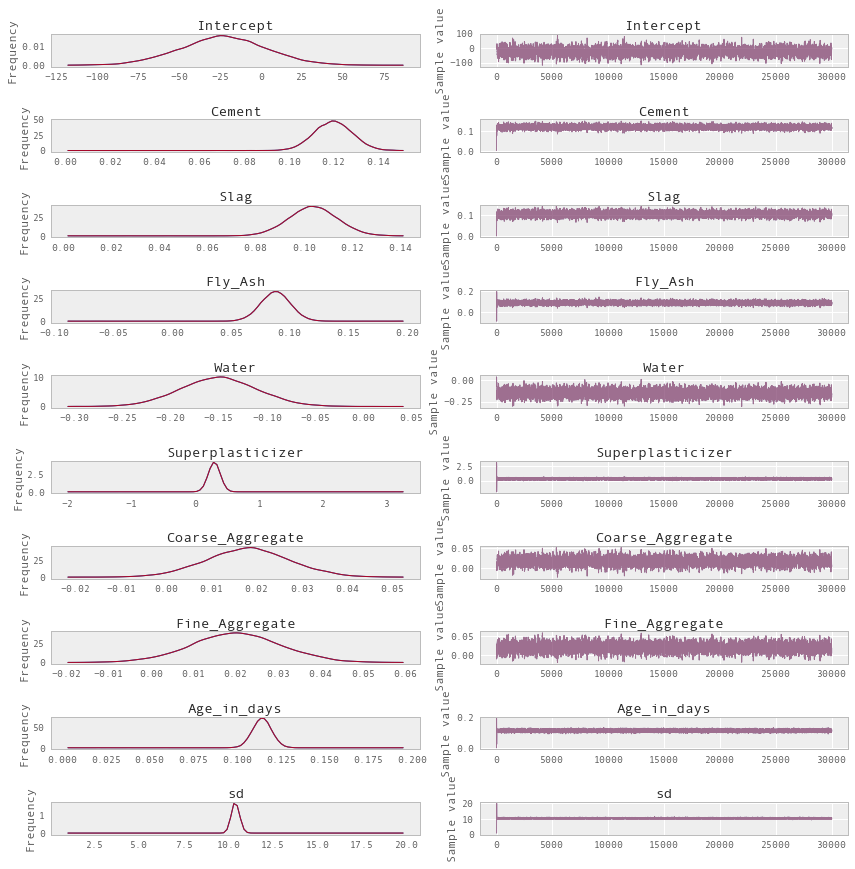

In [41]:
ax = pm.traceplot(trc_nuts[:], figsize=(12,4*3), combined=False)


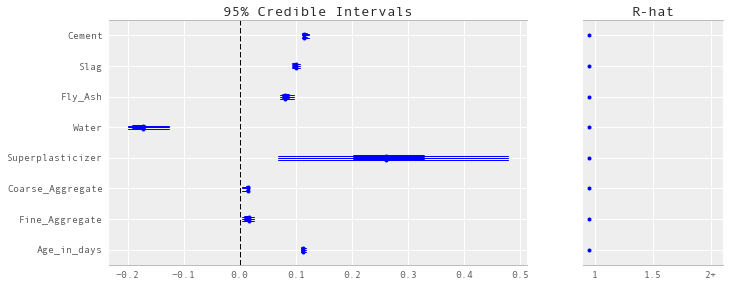

In [27]:
gs = pm.forestplot(trc_nuts[-10:],varnames=training_data.columns.tolist())

- Like the last time looks good except for the Water and Superplasticizer. 
- It takes on the order of 20 minutes to run, which is a long time but not surprising. 

###  NUTS initialise MAP using ADVI mean


In [34]:
with model:
    trc_nuts_map = pm.sample(draws=30000, njobs=3, step=pm.NUTS(), start=v_params.means)

100%|██████████| 30000/30000 [17:35<00:00, 28.41it/s]


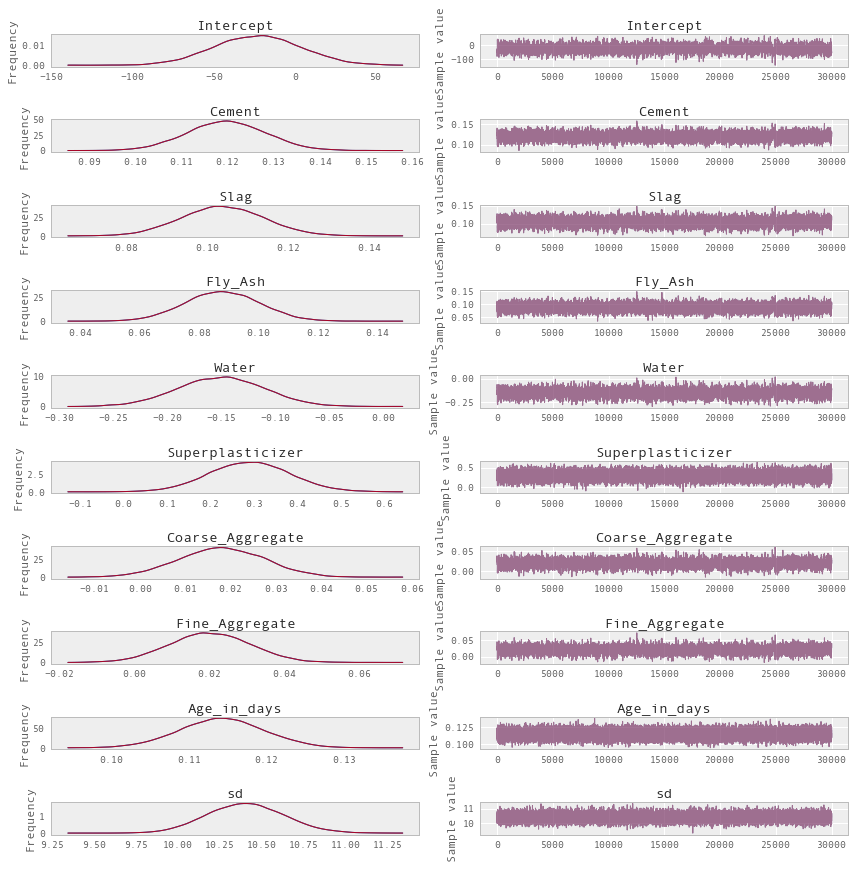

In [40]:
ax = pm.traceplot(trc_nuts_map[:], figsize=(12,4*3), combined=False)

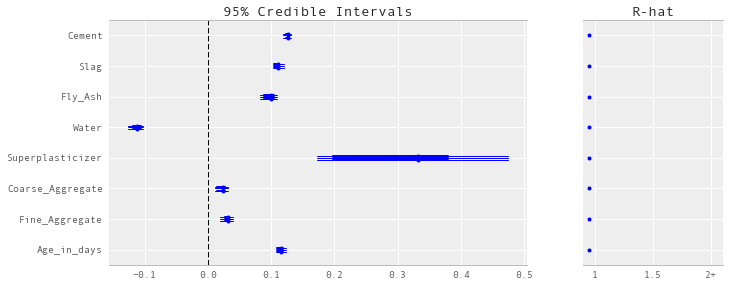

In [36]:
gs = pm.forestplot(trc_nuts_map[-10:],varnames=training_data.columns.tolist())

**Observe**
- Takes about 18 minutes
- Wide variance for Superplasterciszer 


### NUTS initialise MAP using ADVI mean and scale using ADVI stdevs

In [29]:
with model:
    step = pm.NUTS(scaling=np.power(model.dict_to_array(v_params.stds),2), is_cov=True)

    trc_nuts_scale = pm.sample(draws=30000, njobs=3, step=step, start=v_params.means)

100%|██████████| 30000/30000 [16:17<00:00, 30.68it/s]


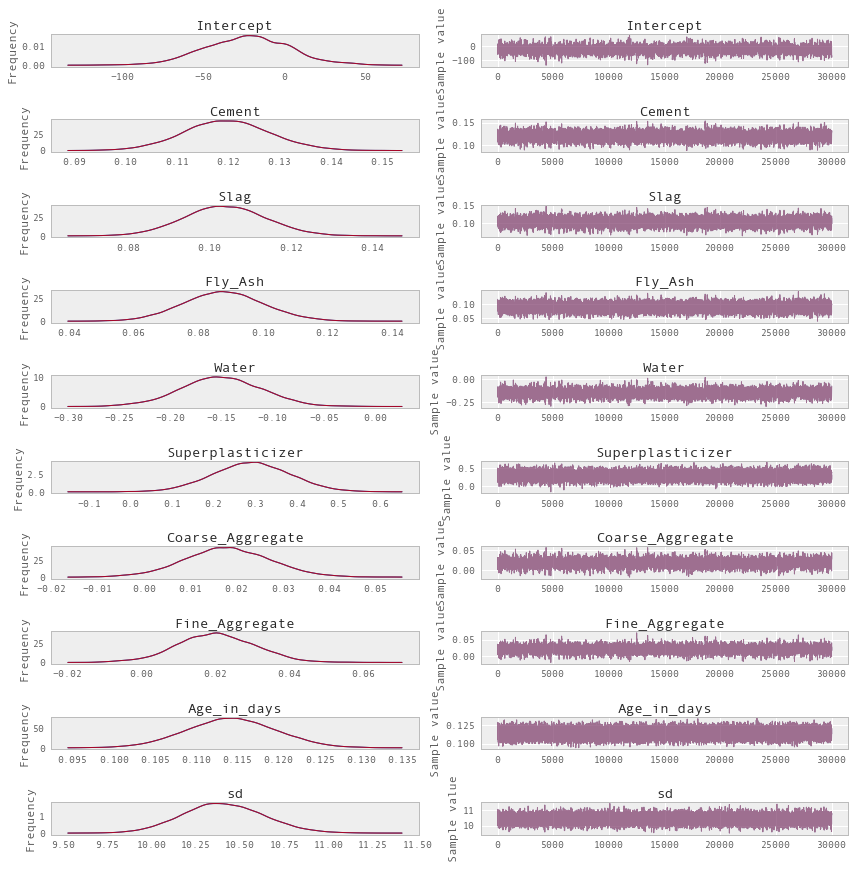

In [39]:
ax = pm.traceplot(trc_nuts_scale[:], figsize=(12,4*3), combined=False)

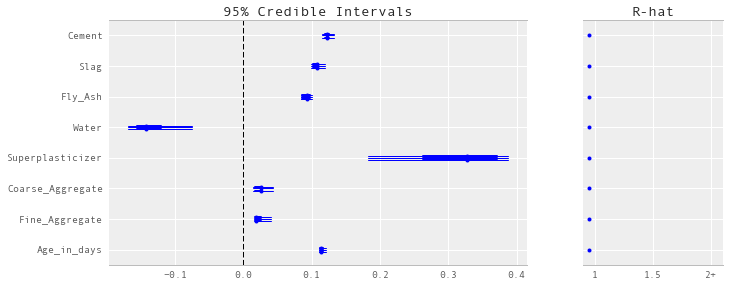

In [31]:
gs = pm.forestplot(trc_nuts_scale[-10:],varnames=training_data.columns.tolist())

**Observe**
- Still a wide variance for Water and Superplasticizer, but it's sharper.
- Takes about 16 minutes. 

# Conclusion.
* It's a good idea here to use the std-deviations to initialize NUTS. 